In [1]:
import warnings
import sys
sys.path.append('../src/utils')

# Core
from utils_functions import *
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2

In [16]:
# Lectura de los subsets
X_train = pd.read_csv('../data/processed/X_train.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')

y_train = pd.read_csv('../data/processed/y_train.csv')
y_val = pd.read_csv('../data/processed/y_val.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

X_train.drop(['hours-per-week'], axis=1, inplace=True)
X_val.drop(['hours-per-week'], axis=1, inplace=True)
X_test.drop(['hours-per-week'], axis=1, inplace=True)

In [17]:
# Optimización de Hiperparámetros
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold

# K-Fold estratificado
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=25)

# Definir el modelo Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight={1: 76.06309812988381, 0: 23.936901870116188})

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': stats.randint(20, 120),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': stats.randint(1, 6)
}

# Definir la métrica log-loss como métrica de evaluación
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(rf_model, 
                                   param_distributions=param_dist, 
                                   n_iter=120, 
                                   scoring=log_loss_scorer,
                                   cv=skfold, 
                                   n_jobs=-1,
                                   random_state=42, 
                                   verbose=0,
                                   refit=True,
                                   return_train_score=True)

# Realizar la búsqueda de hiperparámetros en el conjunto de entrenamiento
random_search.fit(X_train, y_train)

# Obtener el mejor modelo y los mejores hiperparámetros
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Evaluar el mejor modelo en el conjunto de entrenamiento
y_pred_train = best_model.predict_proba(X_train)[:, 1]
train_log_loss = log_loss(y_train, y_pred_train)

# Evaluar el mejor modelo en el conjunto de prueba
y_pred_val = best_model.predict_proba(X_val)[:, 1]
val_log_loss = log_loss(y_val, y_pred_val)

# Imprimir los resultados
print('Mejores hiperparámetros encontrados:')
print(best_params)
print('Log-loss en conjunto de train:', train_log_loss)
print('Log-loss en conjunto de validación:', val_log_loss)

Mejores hiperparámetros encontrados:
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 112}
Log-loss en conjunto de train: 0.4389505259064324
Log-loss en conjunto de prueba: 0.4529885088811111


In [18]:
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

# Predecir probabilidades de clase para datos de prueba
y_pred = best_model.predict_proba(X_val)[:, 1]

# Métricas
print(f'Log-loss of {type(best_model).__name__}: {100*log_loss(y_val, y_pred):0.2f}%')
print(f'Brier Score of {type(best_model).__name__}: {100*brier_score_loss(lb.fit_transform(y_val), y_pred):0.2f}%')

Log-loss of RandomForestClassifier: 45.30%
Brier Score of RandomForestClassifier: 15.17%


In [19]:
from sklearn.calibration import CalibratedClassifierCV
 
calibrated_model = CalibratedClassifierCV(best_model, cv=skfold, method='isotonic', n_jobs=-1)
calibrated_model.fit(X_val, y_val)
calibrated_probs = calibrated_model.predict_proba(X_val)[:, 1]

In [20]:
# Brier score del modelo calibrado
print(f'Log-loss of {type(calibrated_model.estimator).__name__}: {100*log_loss(y_val, calibrated_probs):0.2f}%')
print(f'Brier Score of {type(calibrated_model.estimator).__name__}: {100*brier_score_loss(lb.fit_transform(y_val), calibrated_probs):0.2f}%')

Log-loss of RandomForestClassifier: 35.83%
Brier Score of RandomForestClassifier: 11.66%


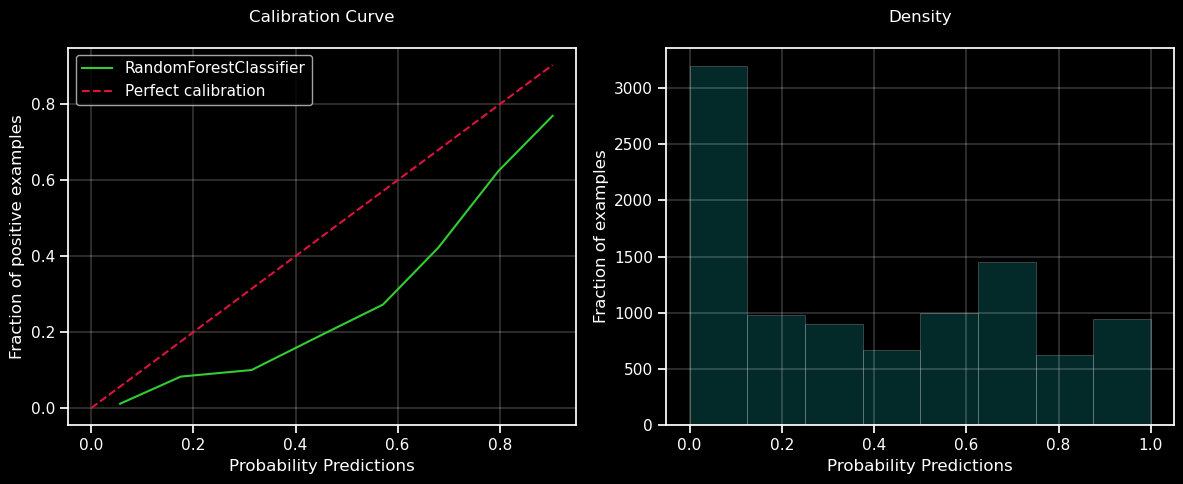

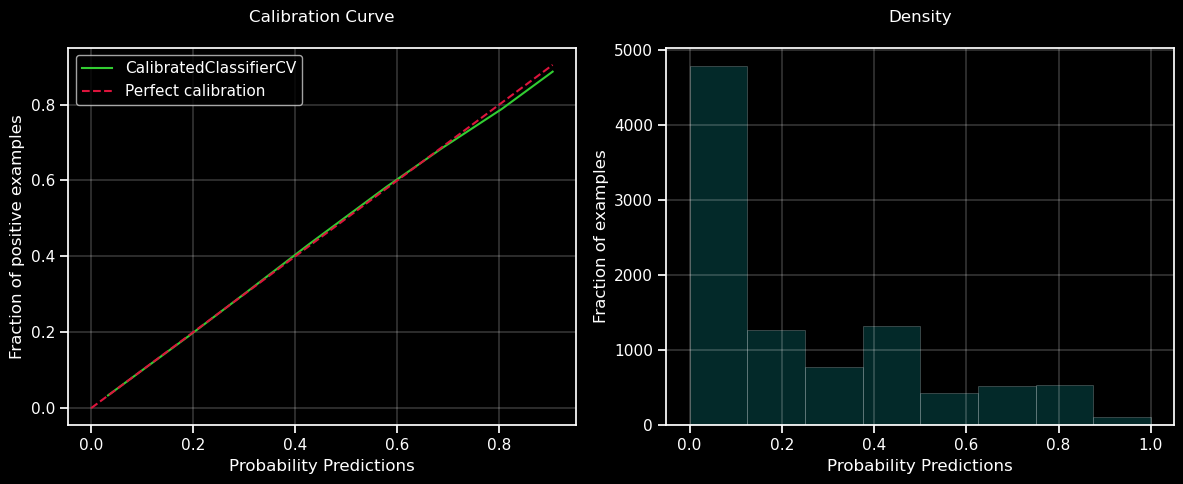

In [21]:
# A nivel visual los resultados de las comparaciones
for modelo, probs in zip([best_model, calibrated_model], [y_pred, calibrated_probs]):
    plot_calibration_curve(lb.fit_transform(y_val), probs, bins=8, model=modelo)

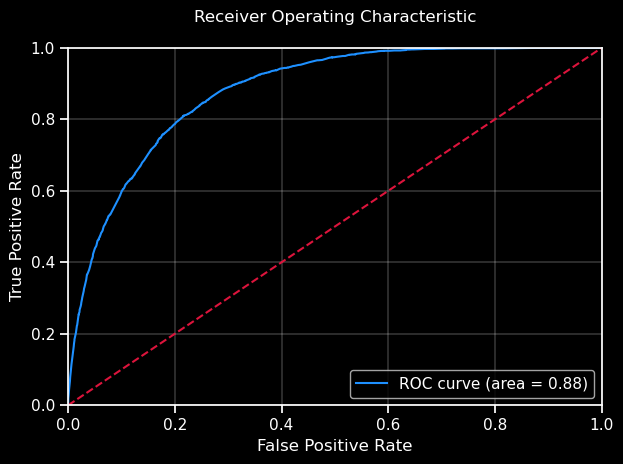

In [22]:
# Curva ROC con el modelo calibrado
roc_curve_plot(model=calibrated_model, 
               X_val=X_val,
               y_val=lb.fit_transform(y_val))

In [23]:
# Reporte de clasificación del modelo calibrado
from sklearn.metrics import classification_report

print(classification_report(y_val, calibrated_model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      7425
           1       0.71      0.48      0.58      2337

    accuracy                           0.83      9762
   macro avg       0.78      0.71      0.73      9762
weighted avg       0.82      0.83      0.82      9762



In [24]:
# Exportando resultados
import joblib

joblib.dump(calibrated_model, f'../models/Optimized{type(calibrated_model.estimator).__name__}.pkl')

['../models/OptimizedRandomForestClassifier.pkl']

---
---